# Fine-tune `roberta-base` model

In this notebook, we will fine-tune [the `roberta-base` model][1], so that it can represent math-specific tokens.

 [1]: https://huggingface.co/roberta-base

In [1]:
! hostname

apollo.fi.muni.cz


In [2]:
from math import ceil
from pathlib import Path

from adaptor.lang_module import LangModule
from adaptor.objectives.MLM import MaskedLanguageModeling
from adaptor.schedules import SequentialSchedule
from adaptor.adapter import Adapter
from adaptor.utils import AdaptationArguments, StoppingStrategy

batch_size: int = 48
effective_batch_size: int = 256

gradient_accumulation_steps = int(ceil(1.0 * effective_batch_size / batch_size))

train_dataset: Path = Path('dataset-text+latex.txt')
input_model_dir: Path = Path('./roberta-base-text+latex/')
objective_dir: Path = Path('./tuned-roberta-base-text+latex.MLM-objective/')
output_model_dir: Path = Path('./tuned-roberta-base-text+latex/')

adaptation_arguments = AdaptationArguments(output_dir=str(objective_dir),
                                           stopping_strategy=StoppingStrategy.FIRST_OBJECTIVE_CONVERGED,
                                           evaluation_strategy='steps', do_train=True, do_eval=True,
                                           gradient_accumulation_steps=gradient_accumulation_steps,
                                           logging_steps=1000, eval_steps=1000, num_train_epochs=5)

if not output_model_dir.exists():
    lang_module = LangModule(str(input_model_dir))
    objectives = MaskedLanguageModeling(lang_module, batch_size=batch_size,
                                        texts_or_path=str(train_dataset))
    schedule = SequentialSchedule([objectives], adaptation_arguments)
    adapter = Adapter(lang_module, schedule, adaptation_arguments)

    adapter.train()  # wait a few hours here
    adapter.save_model(str(output_model_dir))

To validate our model, we will plot the validation loss.

In [3]:
%%capture
! make dataset-text+latex-validation.txt

In [4]:
from itertools import chain
from typing import List, Iterable, Tuple

from tqdm.autonotebook import tqdm

validation_dataset: Path = Path('dataset-text+latex-validation.txt')
evaluations: Path = Path('tuned-roberta-base-text+latex-evaluations.txt')

if not evaluations.exists():
    with evaluations.open('wt') as f:

        def get_checkpoint_number(checkpoint: Path) -> int:
            *_, checkpoint_number = checkpoint.name.split('-')
            return int(checkpoint_number)

        baseline: Tuple[int, str] = (0, 'roberta-base')
        checkpoints: Iterable[Tuple[int, str]] = (
            (get_checkpoint_number(checkpoint), str(checkpoint / 'MaskedLanguageModeling'))
            for checkpoint
            in objective_dir.glob('checkpoint-*')
        )
        checkpoints: List[Tuple[int, str]] = sorted(chain([baseline], checkpoints))

        def get_eval_loss(args: Tuple[int, str]) -> Tuple[int, str, float]:
            checkpoint_number, checkpoint = args
            lang_module = LangModule(checkpoint)
            objectives = MaskedLanguageModeling(lang_module, batch_size=batch_size,
                                                texts_or_path=str(train_dataset),
                                                val_texts_or_path=str(validation_dataset))
            schedule = SequentialSchedule([objectives], adaptation_arguments)
            adapter = Adapter(lang_module, schedule, adaptation_arguments)
            evaluation = adapter.evaluate()
            return (*args, evaluation["eval_loss"])

        for checkpoint_number, checkpoint, eval_loss in tqdm(map(get_eval_loss, checkpoints),
                                                             total=len(checkpoints)):
            print(f'{checkpoint_number}\t{eval_loss}', file=f)

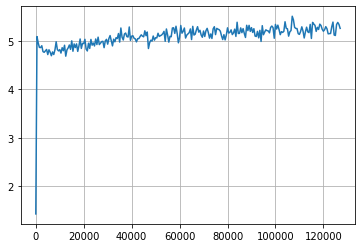

In [5]:
import matplotlib.pyplot as plt

def parse_line(line: str) -> Tuple[int, float]:
    line = line.strip('\r\n')
    checkpoint_number, validation_loss = line.split('\t')
    return int(checkpoint_number), float(validation_loss)

X, Y = zip(*sorted(map(parse_line, evaluations.open('rt'))))
_ = plt.plot(X, Y)
plt.grid()

In [6]:
checkpoint_number, validation_loss = min(filter(lambda line: line[0] > 1,
                                                map(parse_line, evaluations.open('rt'))),
                                         key=lambda line: (line[1], -line[0]))
print(f'We achieved the lowest validation loss ({validation_loss}) in checkpoint number {checkpoint_number}')

We achieved the lowest validation loss (4.687668323516846) in checkpoint number 12500
